In [1]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Specifying the GPU
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
    except RuntimeError as e:
        print(e)

In [3]:
import matplotlib.pyplot as plt
import matplotlib.tri as mtri
import meshio
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 10)
import netCDF4
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, callbacks
from sklearn.metrics import mean_squared_error, mean_absolute_error
import glob
from keras.regularizers import l2
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Reshape

# Function to read mesh from file
def read_mesh(file_name):
    mesh = meshio.read(file_name)
    points = mesh.points
    points = points[:, :2]  # Only keep x and y coordinates
    cells = mesh.cells_dict['triangle']
    return points, cells

# Function to load data from a file
def load_data(file_name, max_frame):
    reader = netCDF4.Dataset(file_name)
    Nodes = np.array([reader.variables['coordx'][:], reader.variables['coordy'][:]])
    Nodes = np.transpose(Nodes)
    disp_x = np.array([reader.variables['vals_nod_var1'][:][0:max_frame]])[0][:][:]
    disp_y = np.array([reader.variables['vals_nod_var2'][:][0:max_frame]])[0][:][:]
    disp_x_second = disp_x[1, :]
    disp_y_second = disp_y[1, :]
    disp = np.column_stack((disp_x_second, disp_y_second))
    return Nodes, disp

In [4]:
# Sorting function to extract numbers from the filename and sort them numerically
def sort_key(s):
    return int(s.split('-')[-1].split('.')[0])

# Loading the image, exodus and csv data
# Sort the mesh files numerically
train_mesh_files = sorted(glob.glob('RRRC-new-data/test-RRRC-*.msh'), key=sort_key)
train_exodus_files = sorted(glob.glob('RRRC-new-data/result-RRRC-*.e'), key=sort_key)

# If you want to split them into train and test sets based on a ratio
train_ratio = 0.8  # for example, 80% training, 20% testing
num_train_files = int(len(train_mesh_files) * train_ratio)

# Split the files into training and testing sets
test_mesh_files = train_mesh_files[num_train_files:]
test_exodus_files = train_exodus_files[num_train_files:]
train_mesh_files = train_mesh_files[:num_train_files]
train_exodus_files = train_exodus_files[:num_train_files]

# Loading CSV parameters
parameters_df = pd.read_csv('RRRC-new-data/circle_data_RRRC.csv')
num_train_params = int(len(parameters_df) * train_ratio)

train_parameters = parameters_df.iloc[:num_train_params].values
test_parameters = parameters_df.iloc[num_train_params:].values

In [23]:
from scipy.interpolate import griddata

# Define the fixed grid size for interpolation
grid_size = 75*75

# Define grid points outside of loop 
grid_x, grid_y = np.mgrid[0:1:np.sqrt(grid_size)*1j, 0:1:np.sqrt(grid_size)*1j]
grid_points = np.c_[grid_x.ravel(), grid_y.ravel()]

def interpolate_nodes_to_fixed_grid(nodes):
    # Interpolate nodes onto the fixed-size grid
    nodes_interpolated = griddata(nodes, nodes, grid_points, method='linear')
    nodes_interpolated = np.clip(nodes_interpolated, 0, 1)
    return nodes_interpolated

def interpolate_displacement_to_fixed_grid(nodes, disp):
    # Interpolate displacement onto the fixed-size grid
    disp_interpolated = griddata(nodes, disp, grid_points, method='linear')
    
    return disp_interpolated

# Data processing loop for training data
train_data_fixed_grid_list = []
train_disp_fixed_grid_list = []

for mesh_file, exodus_file, params in zip(train_mesh_files, train_exodus_files, train_parameters):
    exodus_nodes, disp = load_data(exodus_file, max_frame=2)
    nodes_interpolated = interpolate_nodes_to_fixed_grid(exodus_nodes)
    disp_interpolated = interpolate_displacement_to_fixed_grid(exodus_nodes, disp)

    train_data_fixed_grid_list.append(nodes_interpolated)
    train_disp_fixed_grid_list.append(disp_interpolated)

# Data processing loop for testing data
test_data_fixed_grid_list = []
test_disp_fixed_grid_list = []

for mesh_file, exodus_file, params in zip(test_mesh_files, test_exodus_files, test_parameters):
    exodus_nodes, disp = load_data(exodus_file, max_frame=2)
    nodes_interpolated = interpolate_nodes_to_fixed_grid(exodus_nodes)
    disp_interpolated = interpolate_displacement_to_fixed_grid(exodus_nodes, disp)

    test_data_fixed_grid_list.append(nodes_interpolated)
    test_disp_fixed_grid_list.append(disp_interpolated)

train_data = np.array(train_data_fixed_grid_list)            
test_data = np.array(test_data_fixed_grid_list)            
train_disp = np.array(train_disp_fixed_grid_list) 
test_disp = np.array(test_disp_fixed_grid_list)

In [24]:
#len(test_nodes_list)
print("Shape of train data:", train_data.shape)
print("Shape of train disp:", train_disp.shape)
print("Shape of test data:", test_data.shape)
print("Shape of test disp:", test_disp.shape)

Shape of train data: (80, 5625, 2)
Shape of train disp: (80, 5625, 2)
Shape of test data: (20, 5625, 2)
Shape of test disp: (20, 5625, 2)


In [29]:
#print(mean_absolute_error(train_data[60], train_data[55]))
#print(np.isnan(train_data).any())
test_data[7]

array([[0.        , 0.        ],
       [0.        , 0.01351351],
       [0.        , 0.02702703],
       ...,
       [1.        , 0.97297297],
       [1.        , 0.98648649],
       [1.        , 1.        ]])

In [8]:
print("third train data file: ",train_disp[20])

In [25]:
print("max_train_data =", np.max(train_data))
print("min_train_data =", np.min(train_data))
print("max_train_disp =", np.max(train_disp))
print("min_train_disp =", np.min(train_disp))

max_train_data = 1.0
min_train_data = 0.0
max_train_disp = 1.0000000000000002e-06
min_train_disp = -1.0000000000000002e-06


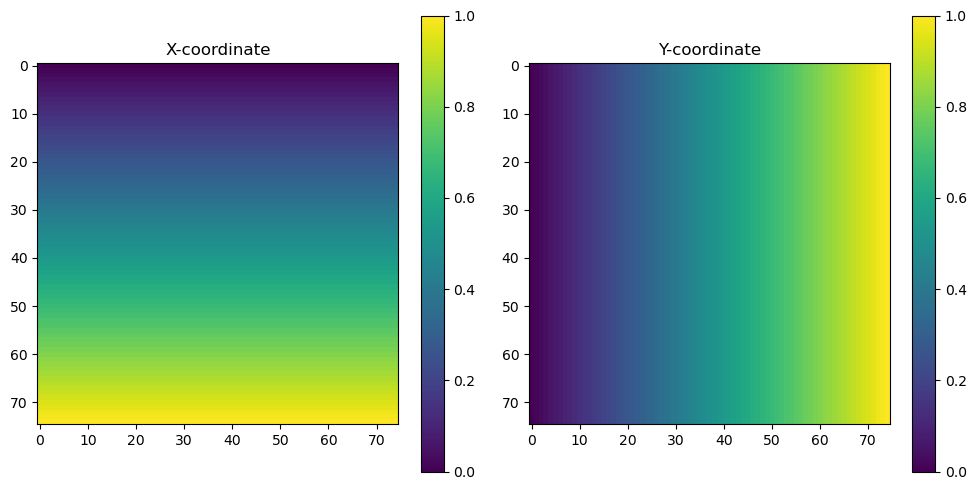

In [29]:
import matplotlib.pyplot as plt

sample_index = 0

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plot x-coordinate
im1 = axes[0].imshow(test_data[sample_index, :, :, 0], cmap='viridis')
axes[0].set_title("X-coordinate")
plt.colorbar(im1, ax=axes[0])

# Plot y-coordinate
im2 = axes[1].imshow(test_data[sample_index, :, :, 1], cmap='viridis')
axes[1].set_title("Y-coordinate")
plt.colorbar(im2, ax=axes[1])

plt.tight_layout()
plt.show()


In [10]:
# Scaling the displacements data

# Get the shape of your original data
original_shape_train = train_disp.shape  
original_shape_test = test_disp.shape    

# Reshape the data to 2D
train_disp_reshaped = train_disp.reshape(-1, original_shape_train[-1])  
test_disp_reshaped = test_disp.reshape(-1, original_shape_test[-1])

# Perform scaling
disp_scaler = MinMaxScaler()
train_disp_scaled = disp_scaler.fit_transform(train_disp_reshaped)
test_disp_scaled = disp_scaler.transform(test_disp_reshaped)

# Reshape back to the original shape
train_disp_scaled = train_disp_scaled.reshape(original_shape_train)
test_disp_scaled = test_disp_scaled.reshape(original_shape_test)

print("Shape of train disp scaled:", train_disp_scaled.shape)

Shape of train disp scaled: (80, 75, 75, 2)


In [11]:
max_disp = np.max(train_disp_scaled)
min_disp = np.min(train_disp_scaled)
print(f"Max disp: {max_disp}")
print(f"Min disp: {min_disp}")

Max disp: 1.0
Min disp: 0.0


In [12]:
# Building the CNN model
model = Sequential()

# Add the Convolutional layers
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(75, 75, 1)))  # 1 channel for distance data
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))

# Convert the 2D feature maps to vectors
model.add(Flatten())

# Add a Dense layer to produce the displacements
model.add(Dense(75*75*2, activation='linear'))  # Producing x and y displacements for the 75x75 grid

# Add a Reshape layer to match the target shape
model.add(Reshape((75, 75, 2)))

from tensorflow.keras.optimizers import Adam
optimizer = Adam(learning_rate=0.0001)

# Compile the model
model.compile(optimizer=optimizer, loss='mse')

# Reshape train_data for compatibility with the CNN input
train_data_reshaped = train_data.reshape((-1, 75, 75, 1))

# Train the model with the added callback
history = model.fit(train_data_reshaped, train_disp_scaled, validation_split=0.2, batch_size=32, epochs=100, 
                    callbacks=[keras.callbacks.EarlyStopping(patience=10)])

# Evaluate the model (ensure you reshape the test data as well)
test_data_reshaped = test_data.reshape((-1, 75, 75, 1))
model.evaluate(test_data_reshaped, test_disp_scaled)


Epoch 1/100
2/2 [==============================] - 4s 169ms/step - loss: 0.2844 - val_loss: 0.2309
Epoch 2/100
2/2 [==============================] - 0s 58ms/step - loss: 0.2049 - val_loss: 0.1445
Epoch 3/100
2/2 [==============================] - 0s 57ms/step - loss: 0.1212 - val_loss: 0.0672
Epoch 4/100
2/2 [==============================] - 0s 59ms/step - loss: 0.0518 - val_loss: 0.0225
Epoch 5/100
2/2 [==============================] - 0s 58ms/step - loss: 0.0214 - val_loss: 0.0258
Epoch 6/100
2/2 [==============================] - 0s 57ms/step - loss: 0.0317 - val_loss: 0.0416
Epoch 7/100
2/2 [==============================] - 0s 58ms/step - loss: 0.0417 - val_loss: 0.0331
Epoch 8/100
2/2 [==============================] - 0s 57ms/step - loss: 0.0302 - val_loss: 0.0165
Epoch 9/100
2/2 [==============================] - 0s 57ms/step - loss: 0.0156 - val_loss: 0.0082
Epoch 10/100
2/2 [==============================] - 0s 57ms/step - loss: 0.0102 - val_loss: 0.0092
Epoch 11/100
2/2 [

0.005936063826084137

In [26]:
from tensorflow.keras import layers, models

# Define the model with LSTM layers
model = models.Sequential([
    layers.Input(shape=(5625, 2)),  # Input shape (5625, 2) and output shape is same (5625, 2)
    layers.LSTM(256, return_sequences=True, dropout=0.2),  # LSTM layer with return sequences and dropout
    layers.LSTM(512, return_sequences=True, dropout=0.2),  # Another LSTM layer with return sequences and dropout
    layers.TimeDistributed(layers.Dense(2, activation='linear'))  # TimeDistributed layer to apply Dense to each time step
])

# Define the learning rate
lr = 0.0001

# Compile your model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr), loss='mse')
model.summary()

# The ReduceLROnPlateau callback adjusts the learning rate during training when a monitored quantity has stopped improving
from tensorflow.keras.callbacks import ReduceLROnPlateau

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-6)

# Train the model with the added callback
history = model.fit(train_data, train_disp_scaled, validation_split=0.2, batch_size=32, epochs=100, 
                    callbacks=[keras.callbacks.EarlyStopping(patience=10), reduce_lr])

# Evaluate the model
model.evaluate(test_data, test_disp_scaled)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 5625, 256)         265216    
                                                                 
 lstm_3 (LSTM)               (None, 5625, 512)         1574912   
                                                                 
 time_distributed_1 (TimeDis  (None, 5625, 2)          1026      
 tributed)                                                       
                                                                 
Total params: 1,841,154
Trainable params: 1,841,154
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
2/2 [==============================] - 4s 1000ms/step - loss: 0.2611 - val_loss: 0.2216 - lr: 1.0000e-04
Epoch 2/100
2/2 [==============================] - 1s 680ms/step - loss: 0.2026 - val_loss: 0.1668 - lr: 1.0000e-04
Epoch 3/1

0.058244489133358

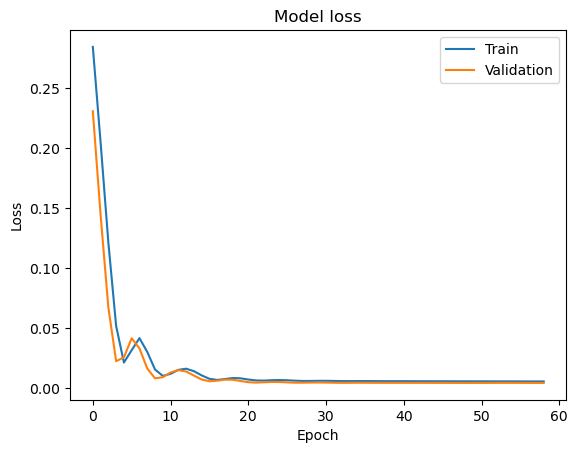

In [13]:
# plot training and validation loss over epochs
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [14]:
# Predict using the model
test_data_reshaped = test_data.reshape((-1, 75, 75, 1))
predicted_disp_scaled = model.predict(test_data_reshaped)

# Reshape the predictions to 2D
predicted_disp_reshaped = predicted_disp_scaled.reshape(-1, original_shape_test[-1])

# Use the inverse_transform function of the scaler
predicted_disp_unscaled = disp_scaler.inverse_transform(predicted_disp_reshaped)

# Reshape the unscaled predictions back to their original shape
predictions = predicted_disp_unscaled.reshape(original_shape_test)

print("Shape of reshaped test data:", test_data_reshaped.shape)
print("Shape of predictions scaled:", predicted_disp_scaled.shape)
print("Shape of predictions unscaled:", predicted_disp_unscaled.shape)
print("Length of original predictions:", len(predictions))


1/1 [==============================] - 0s 48ms/step
Shape of reshaped test data: (20, 75, 75, 1)
Shape of predictions scaled: (20, 75, 75, 2)
Shape of predictions unscaled: (112500, 2)
Length of original predictions: 20


In [14]:
test_disp_check = disp_scaler.inverse_transform(test_disp_scaled.reshape(-1, original_shape_test[-1]))
if np.allclose(test_disp_check, test_disp_reshaped):
    print("Inverse transformation is correct.")
else:
    print("There's an issue with inverse transformation.")

Inverse transformation is correct.


In [15]:
# Extract the x and y displacements from the predictions and actual values
predicted_disp_x = predictions[:, :, :, 0]
predicted_disp_y = predictions[:, :, :, 1]

actual_disp_x = test_disp[:, :, :, 0]
actual_disp_y = test_disp[:, :, :, 1]

# Reshape to 2D
actual_disp_x_2d = actual_disp_x.reshape(actual_disp_x.shape[0], -1)
predicted_disp_x_2d = predicted_disp_x.reshape(predicted_disp_x.shape[0], -1)

actual_disp_y_2d = actual_disp_y.reshape(actual_disp_y.shape[0], -1)
predicted_disp_y_2d = predicted_disp_y.reshape(predicted_disp_y.shape[0], -1)

# Compute MSE and MAE for disp_x
mse_x = mean_squared_error(actual_disp_x_2d, predicted_disp_x_2d)
mae_x = mean_absolute_error(actual_disp_x_2d, predicted_disp_x_2d)

# Compute MSE and MAE for disp_y
mse_y = mean_squared_error(actual_disp_y_2d, predicted_disp_y_2d)
mae_y = mean_absolute_error(actual_disp_y_2d, predicted_disp_y_2d)


print("MSE for disp_x:", mse_x)
print("MAE for disp_x:", mae_x)
print("\n")
print("MSE for disp_y:", mse_y)
print("MAE for disp_y:", mae_y)


MSE for disp_x: 7.103499901580019e-15
MAE for disp_x: 6.555595900811498e-08


MSE for disp_y: 2.9099319607744695e-14
MAE for disp_y: 1.1639701439318668e-07


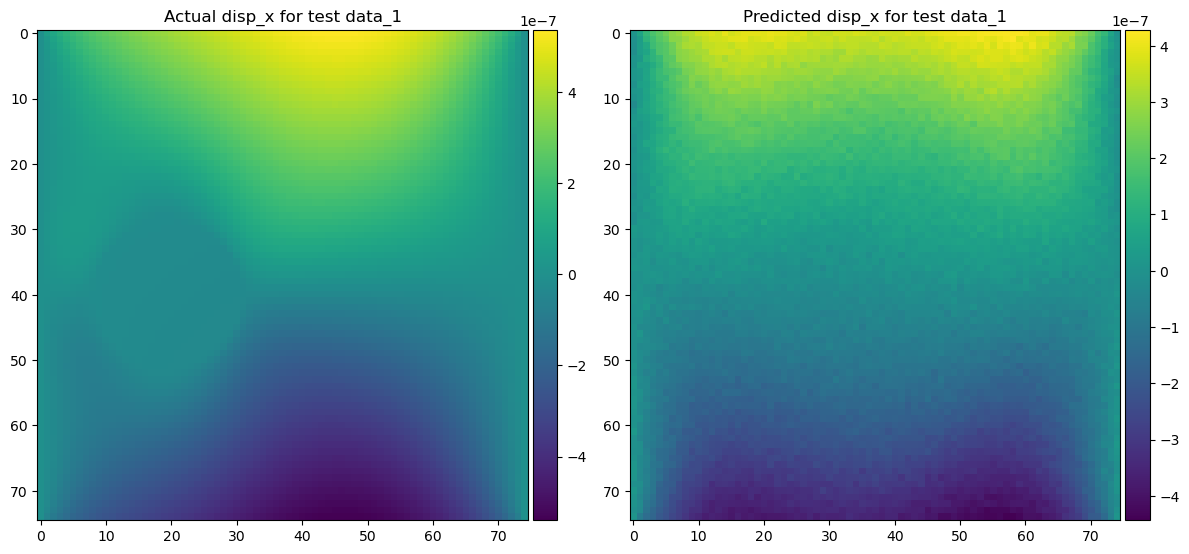

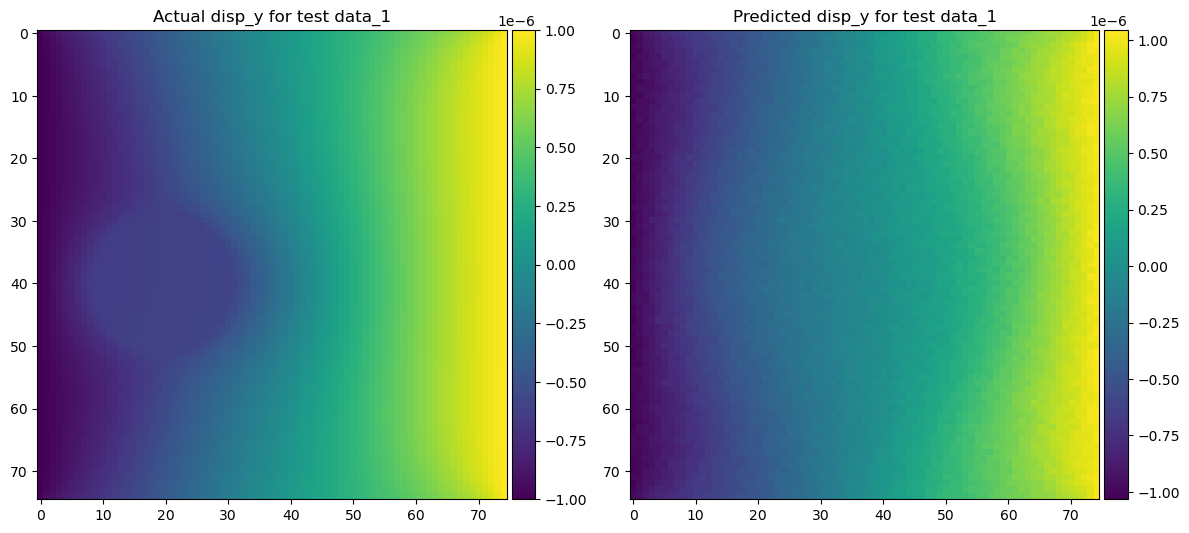

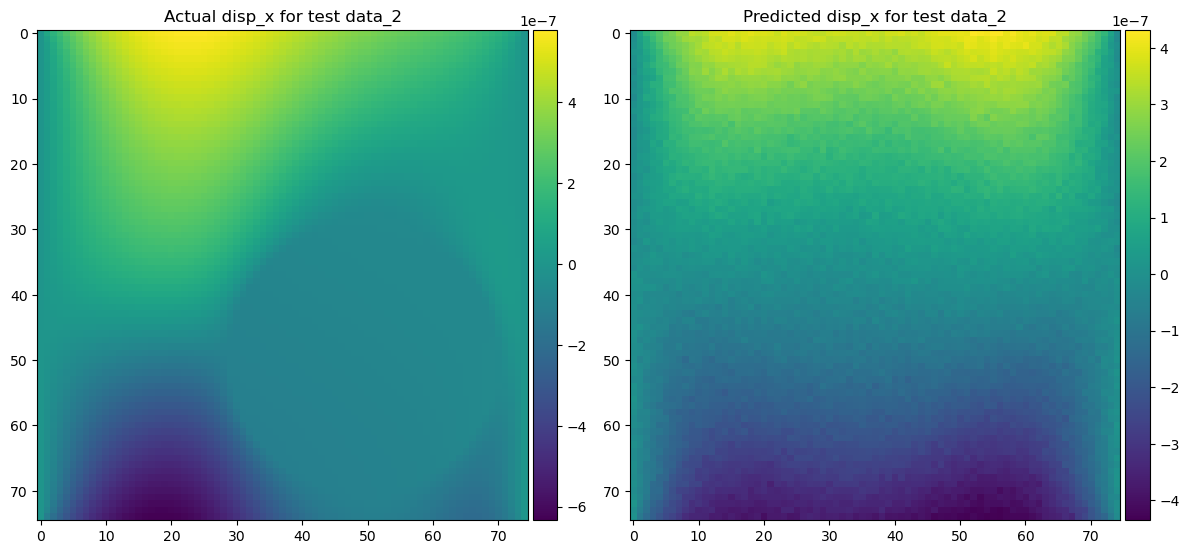

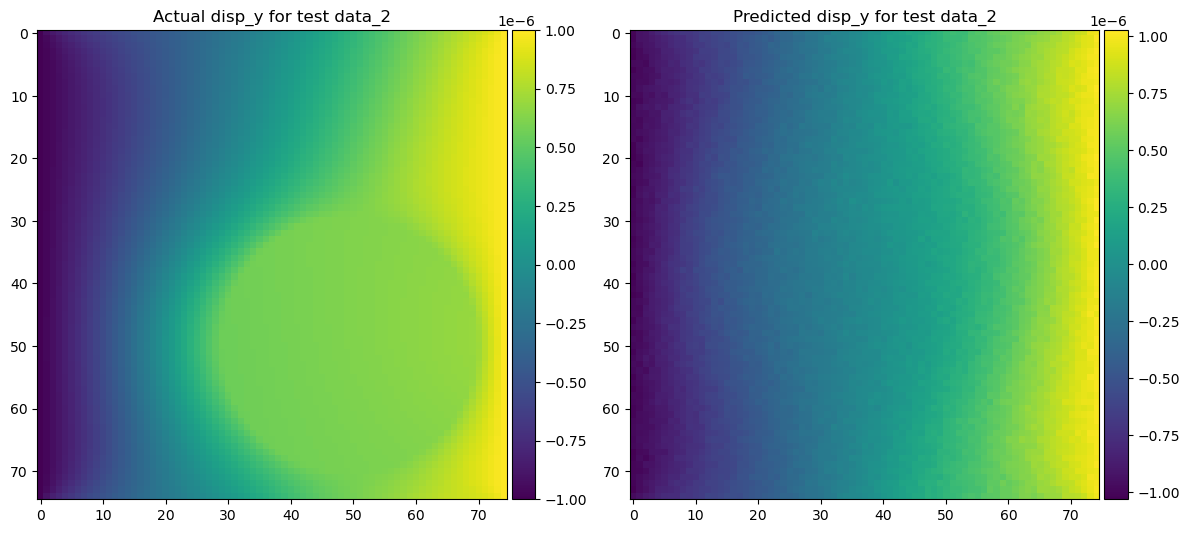

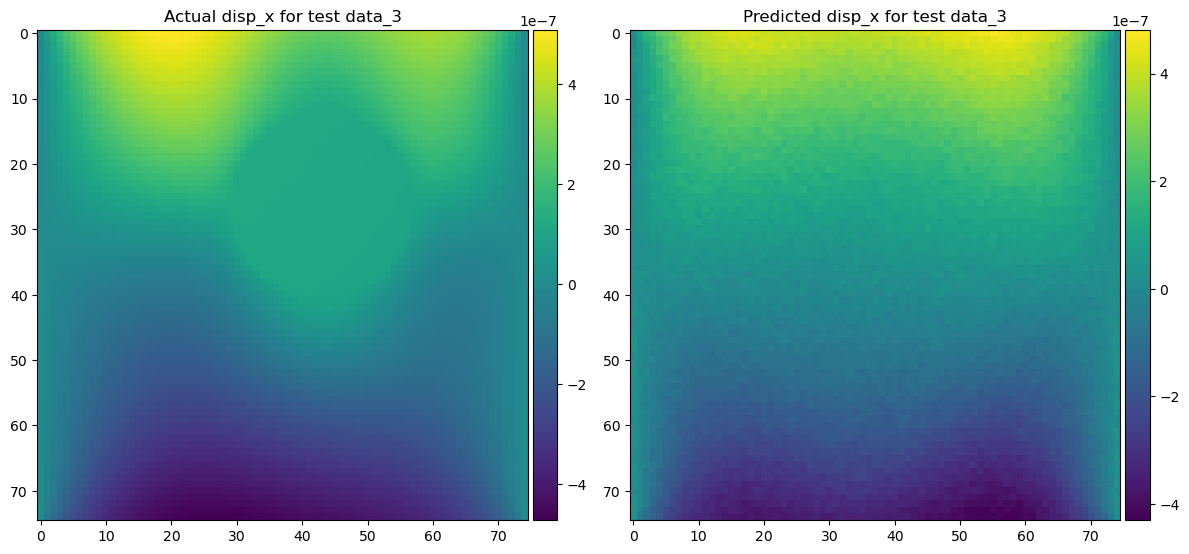

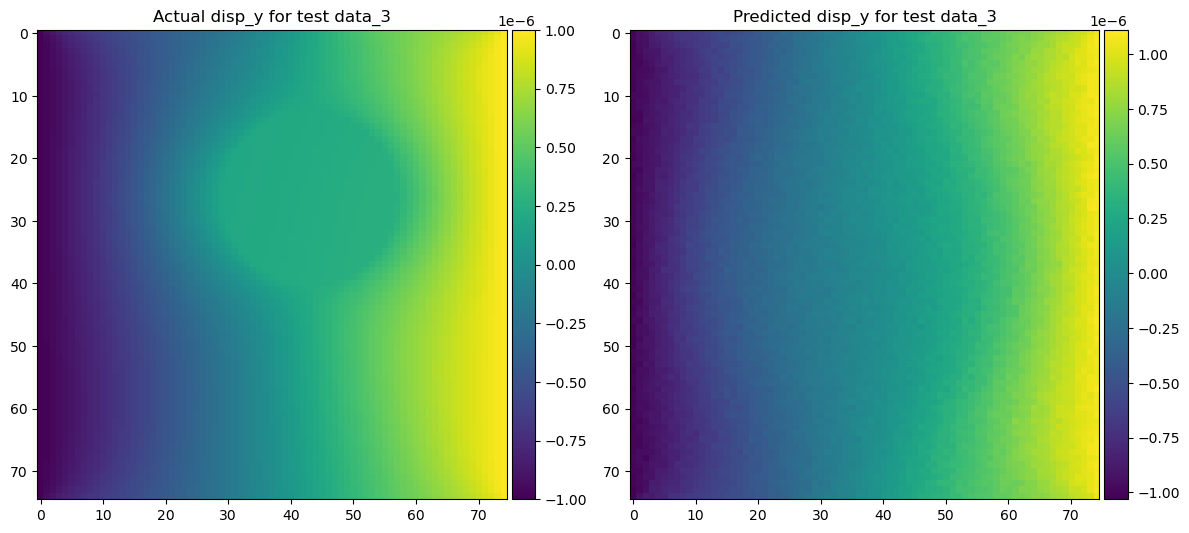

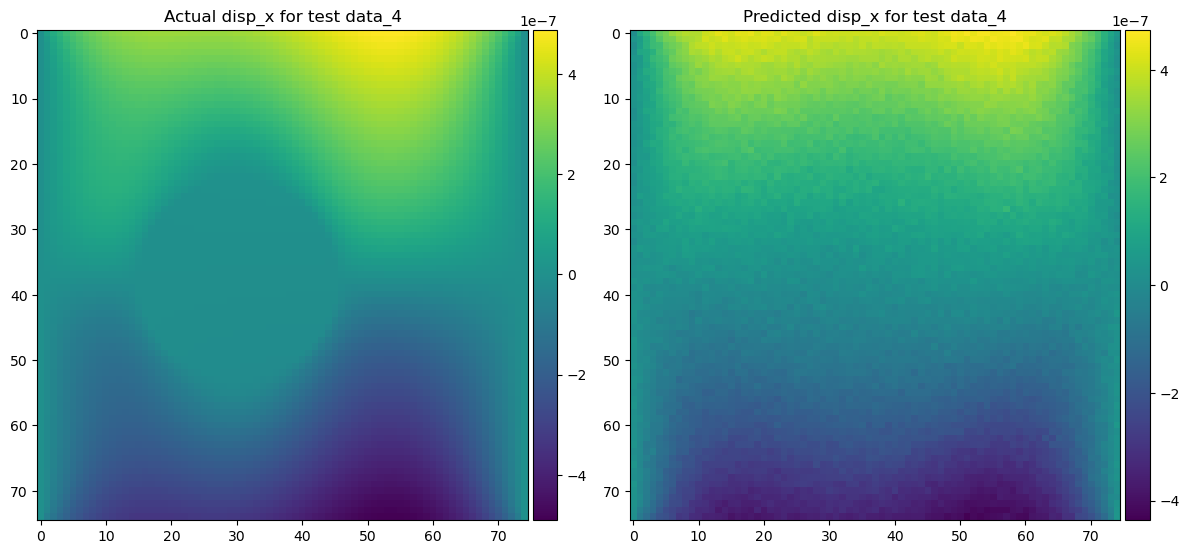

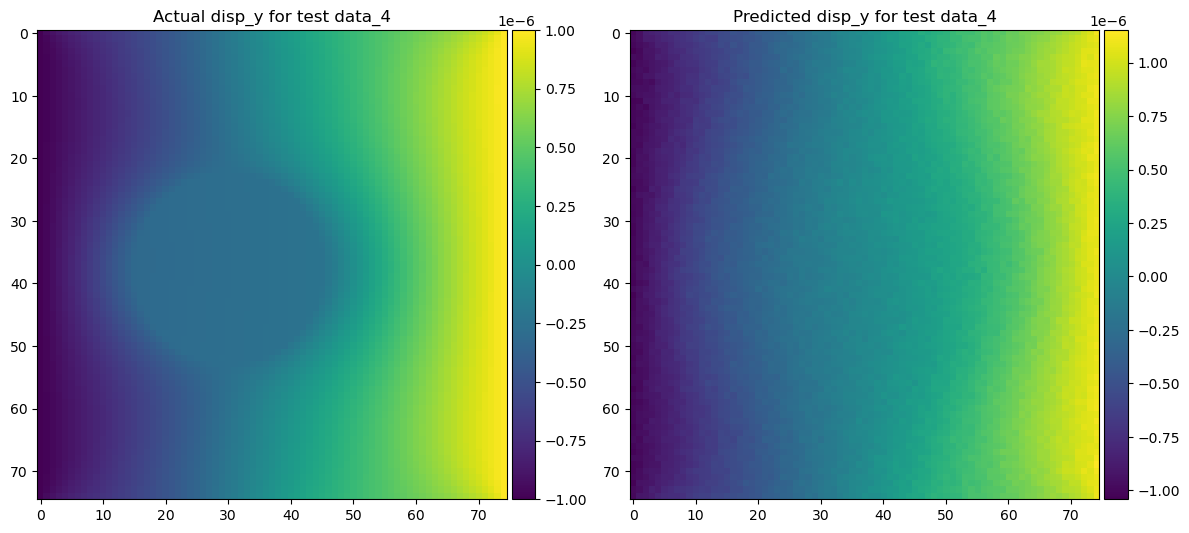

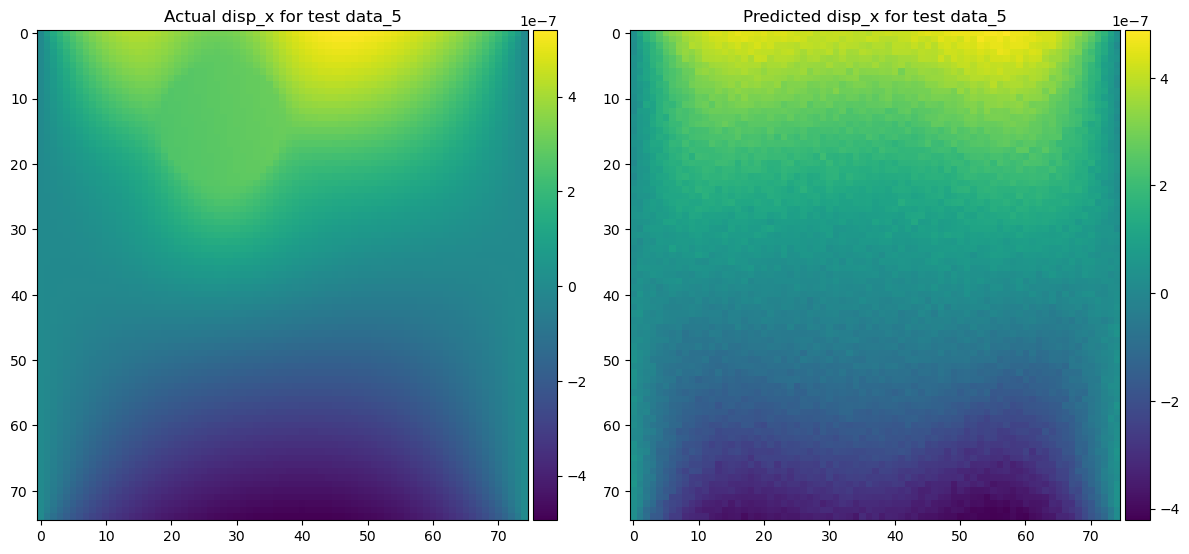

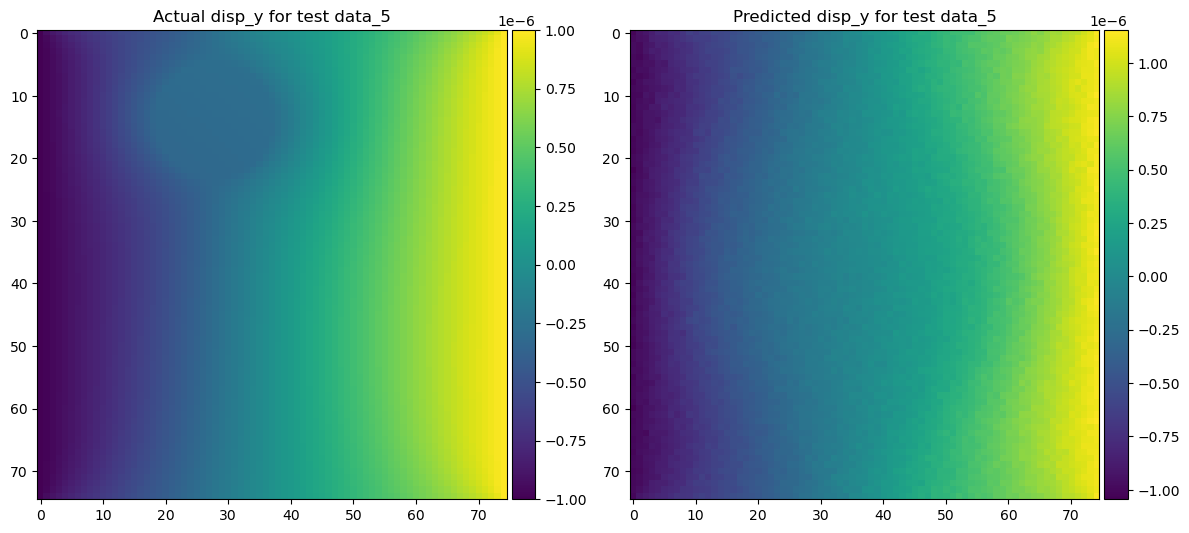

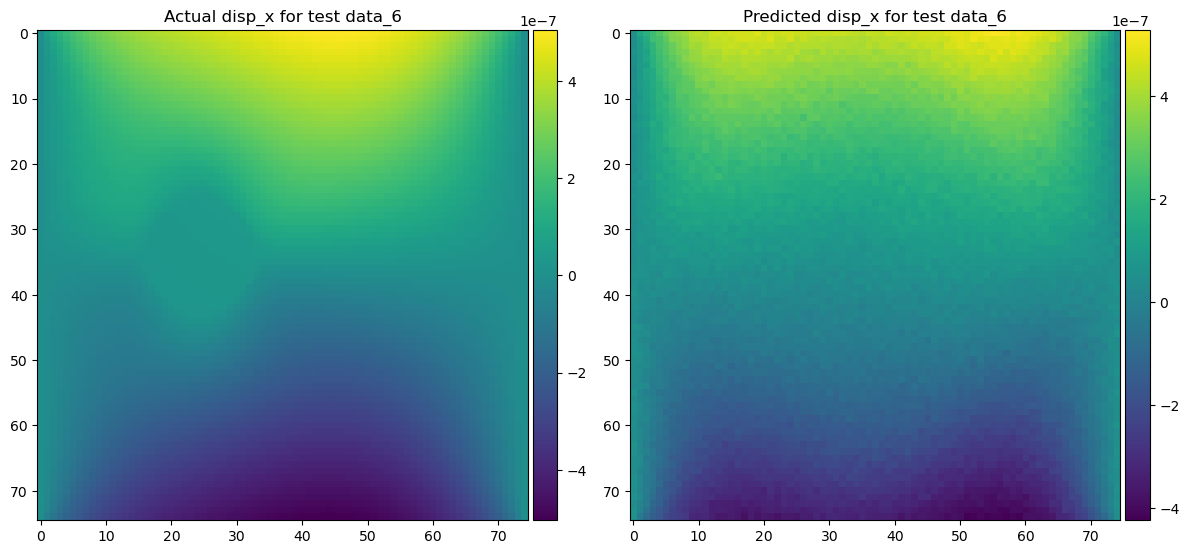

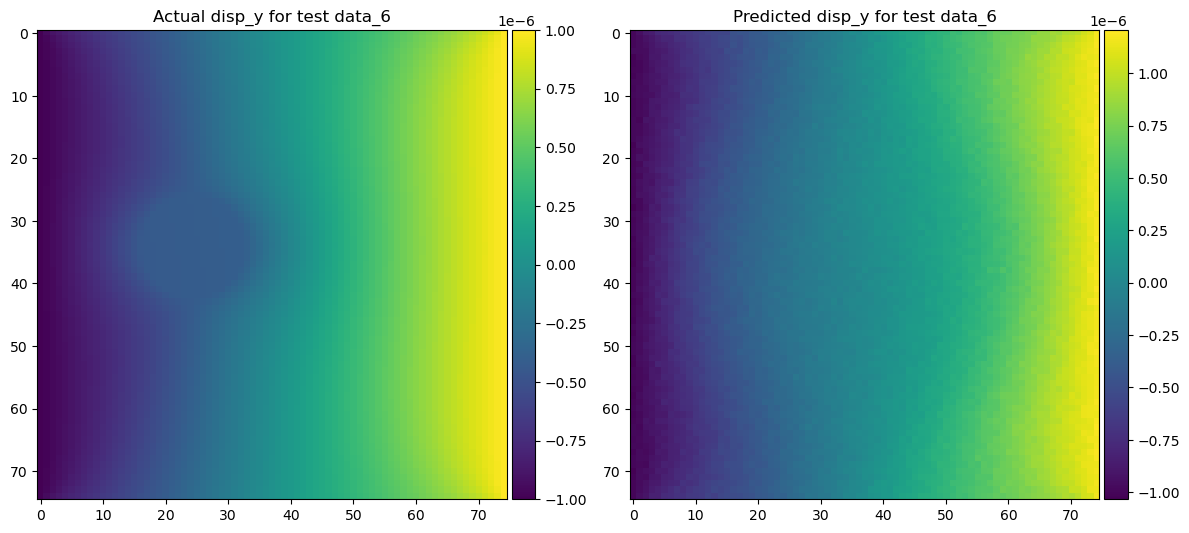

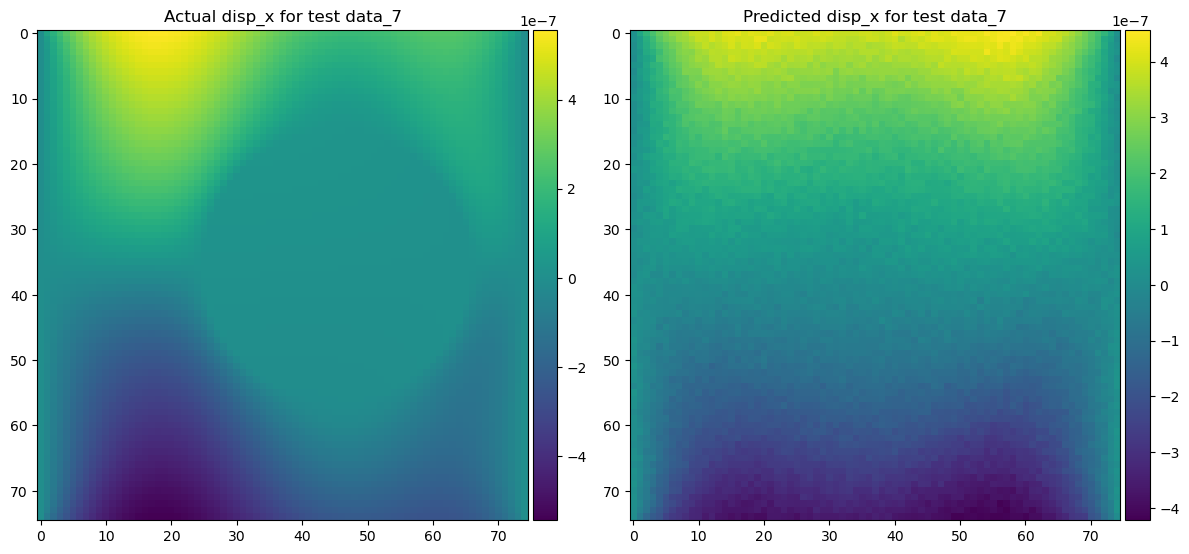

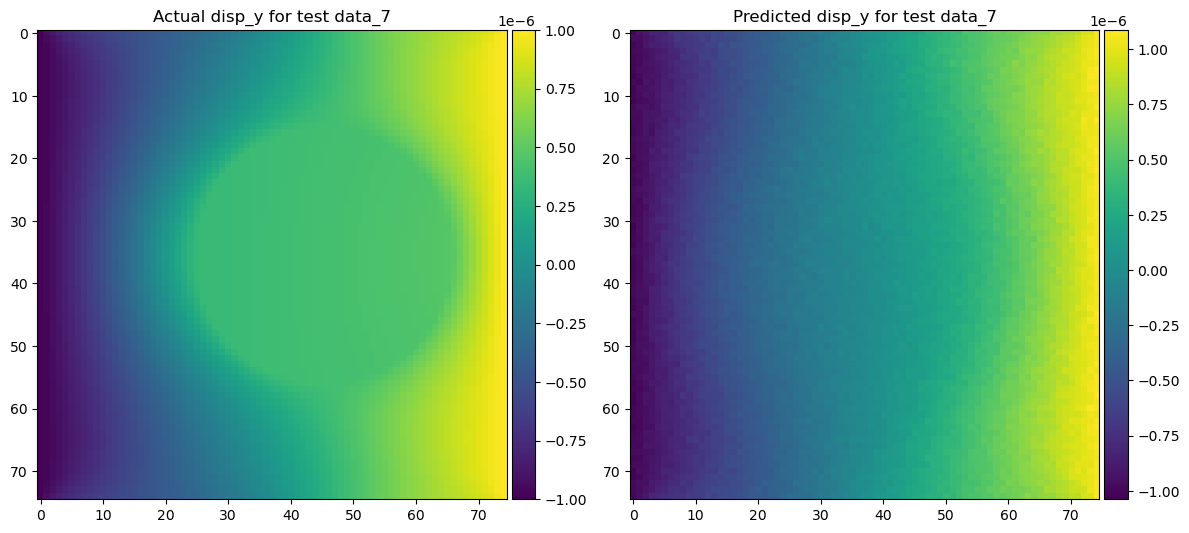

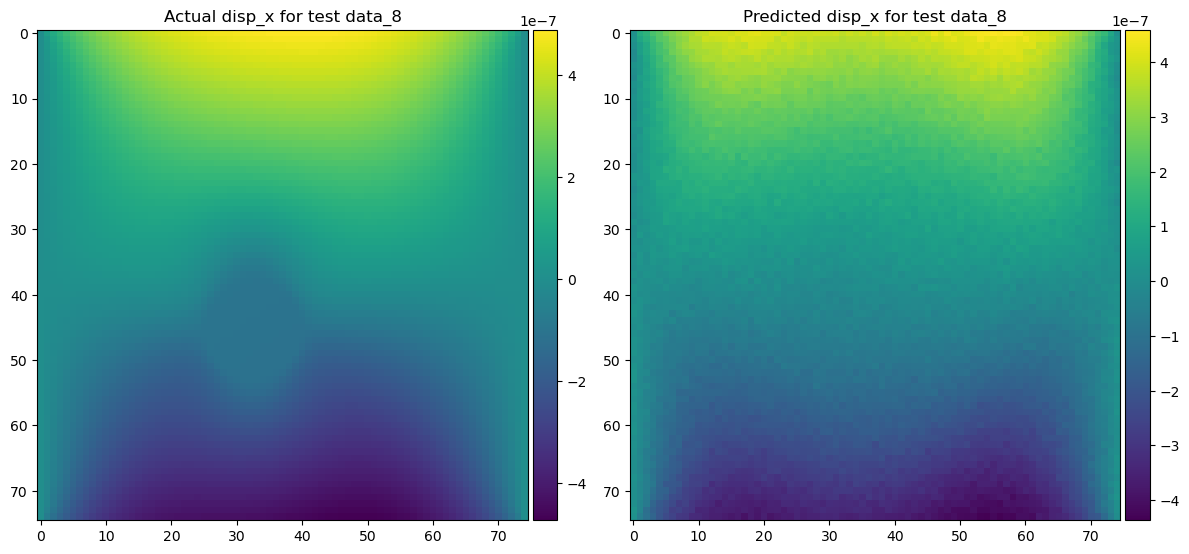

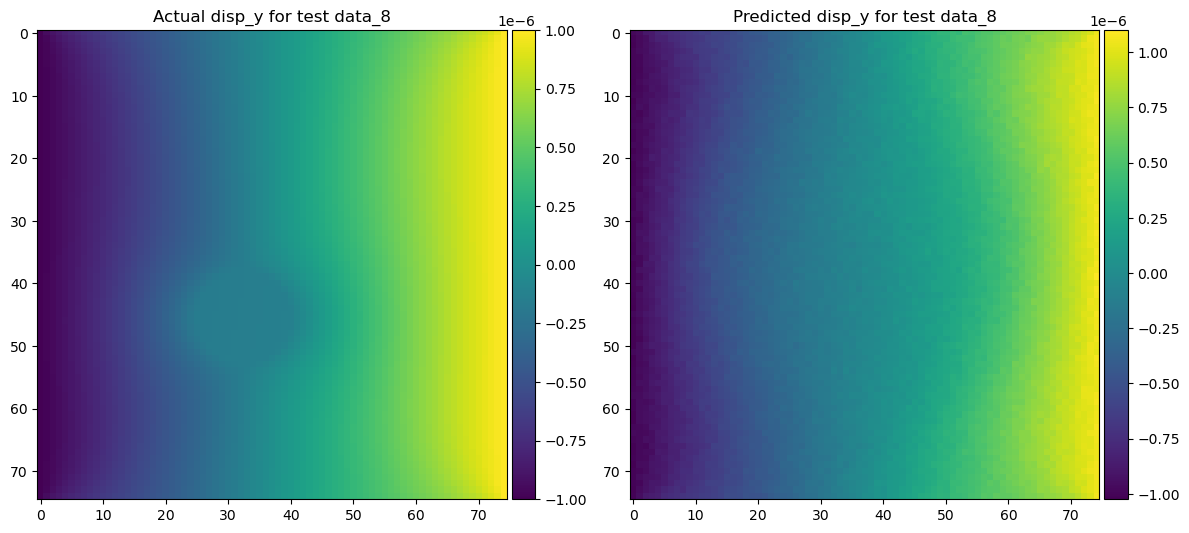

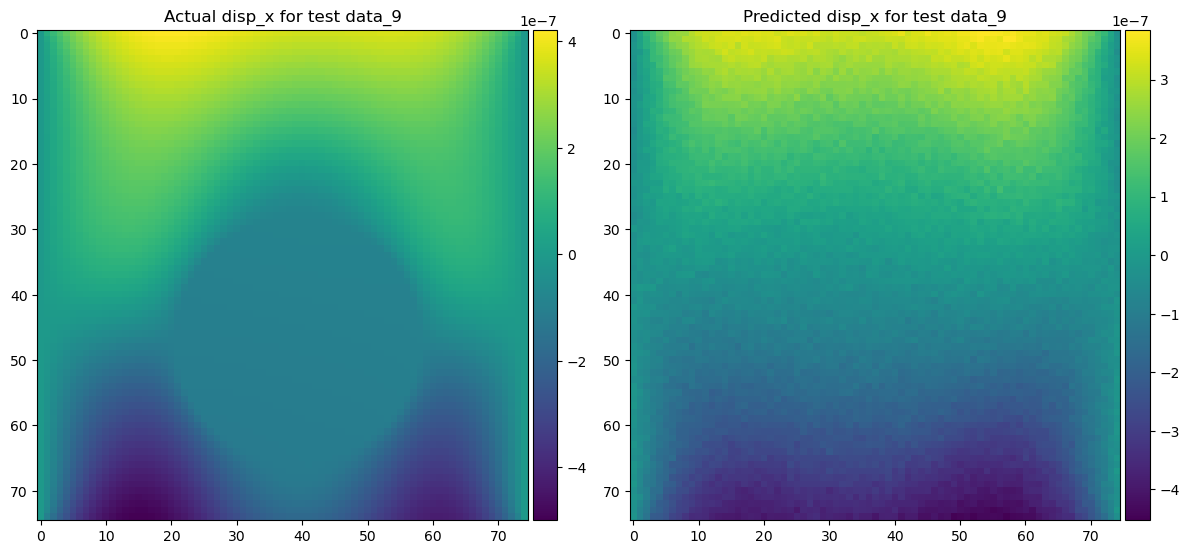

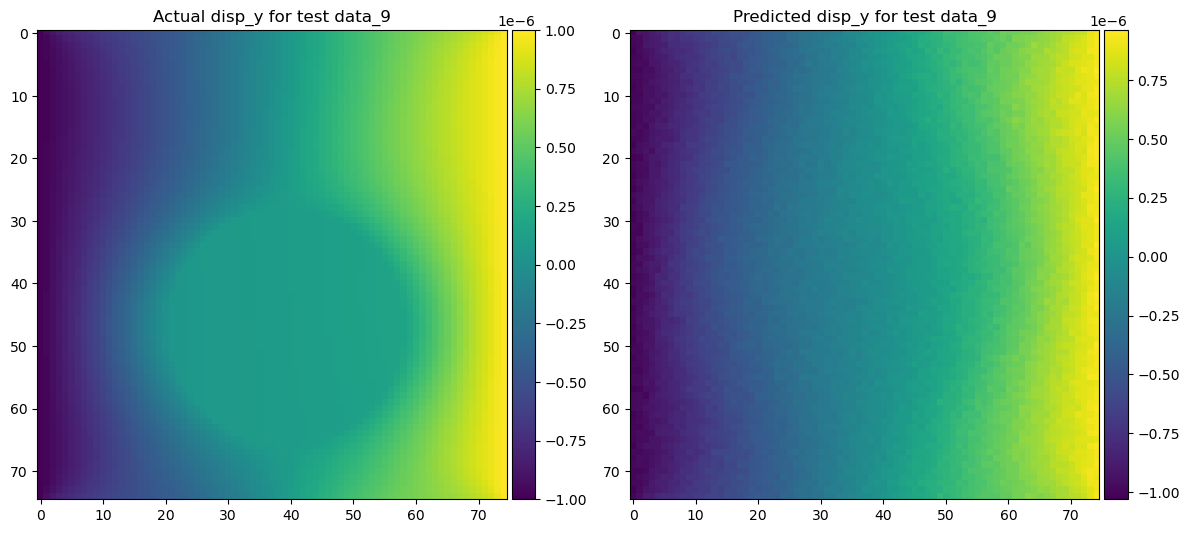

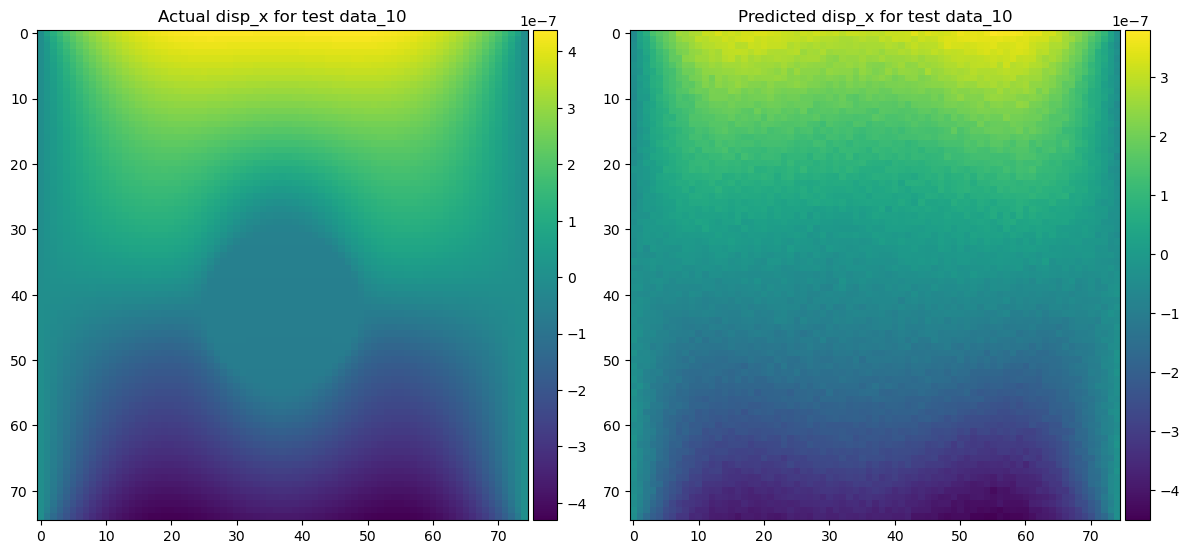

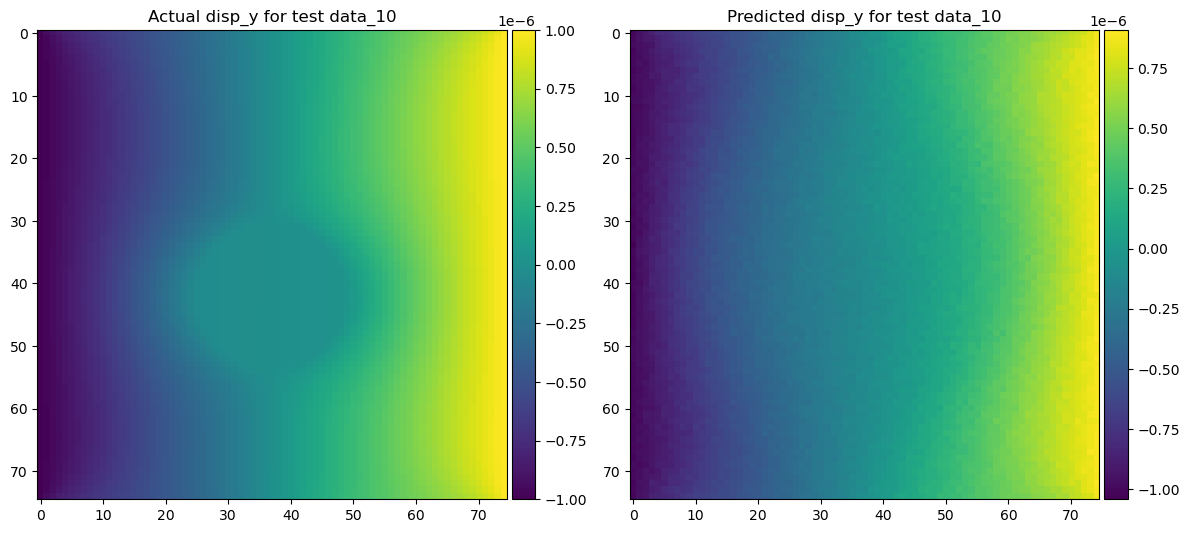

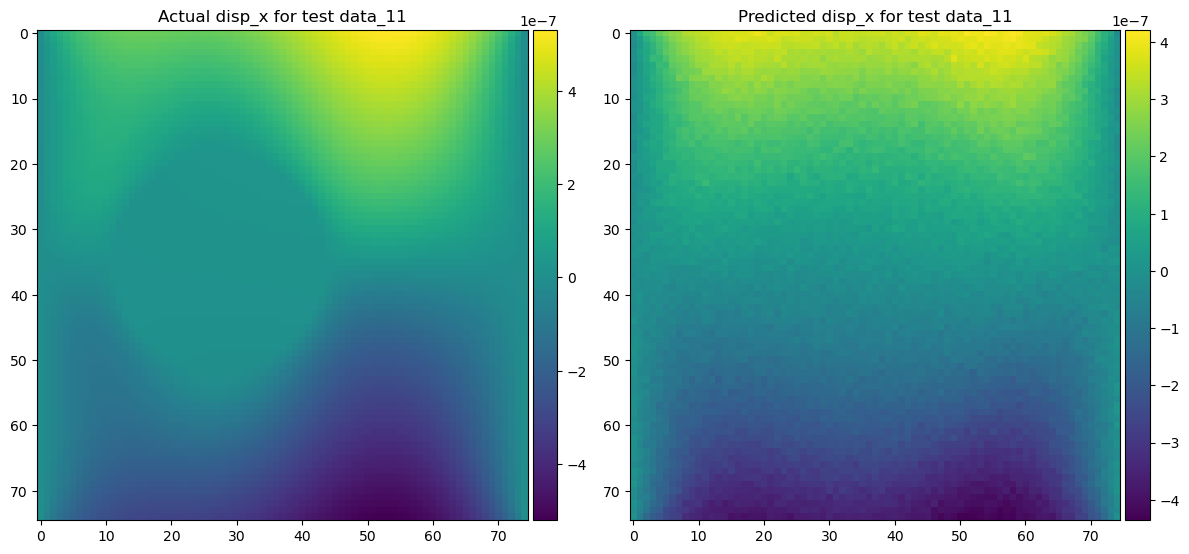

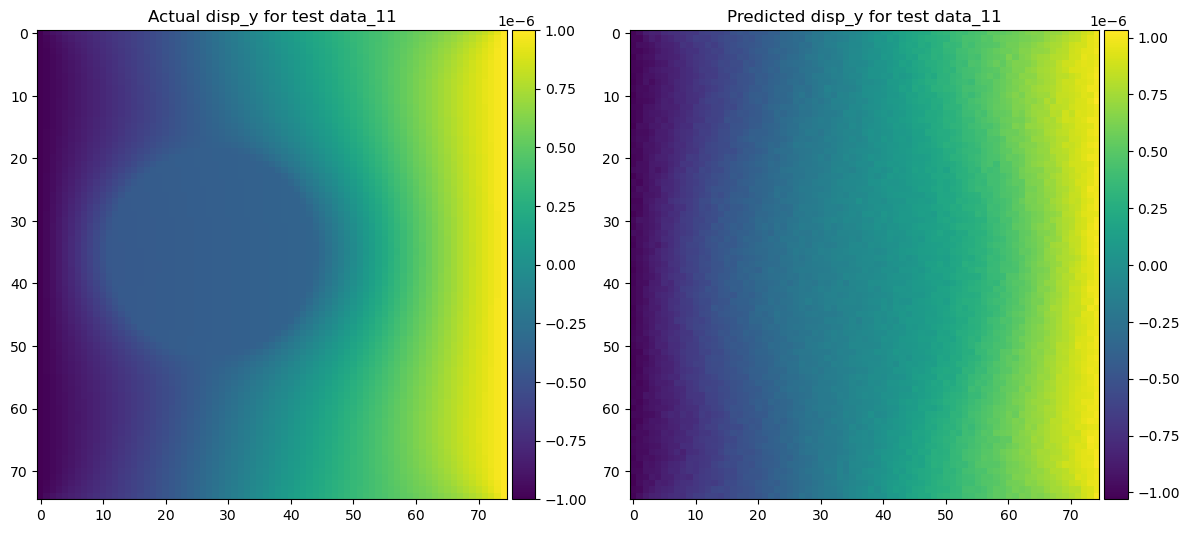

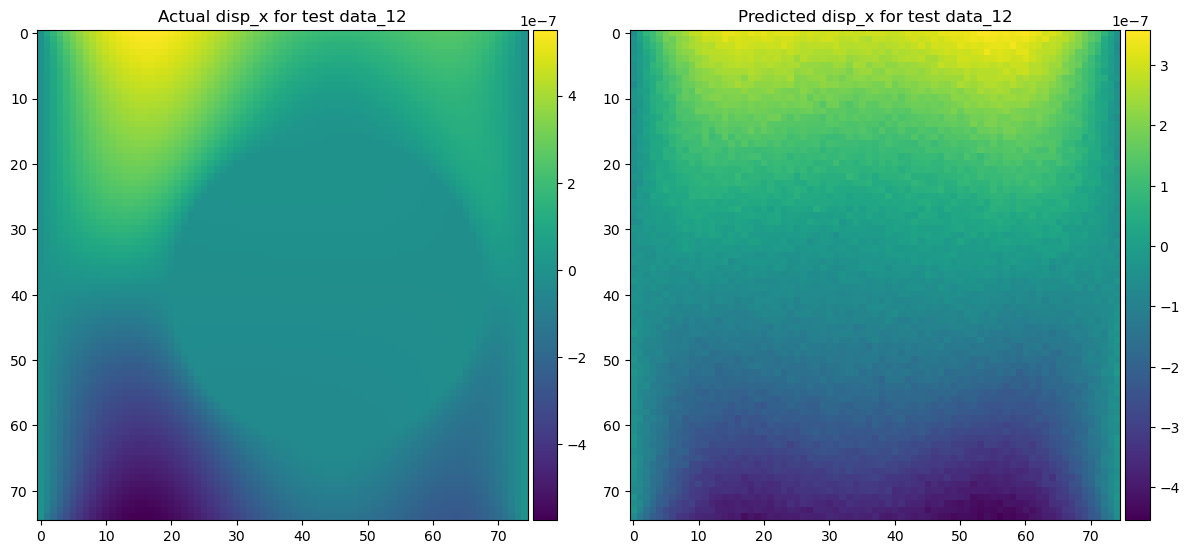

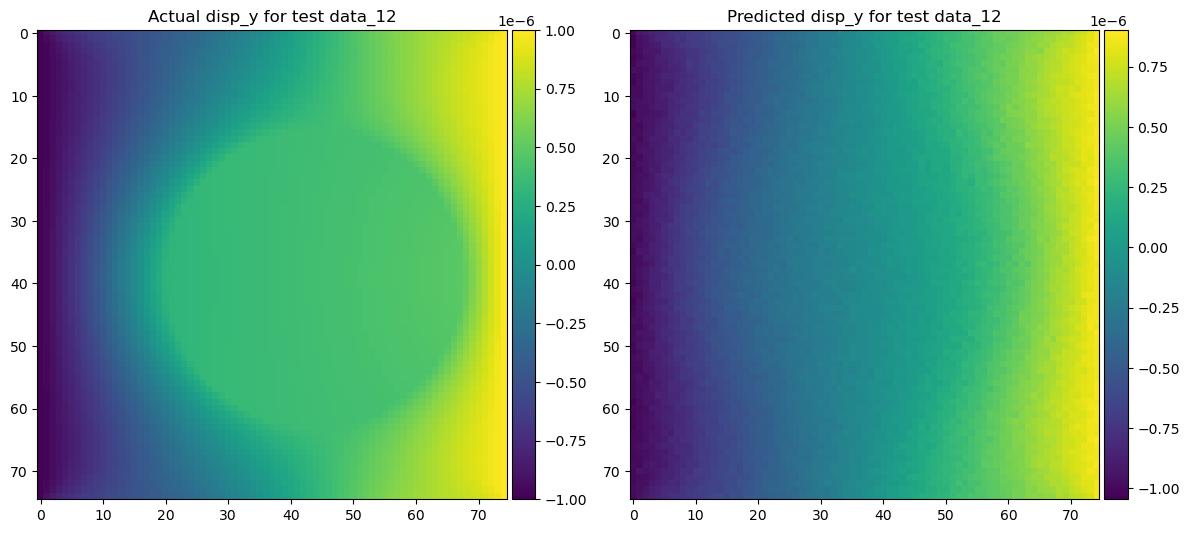

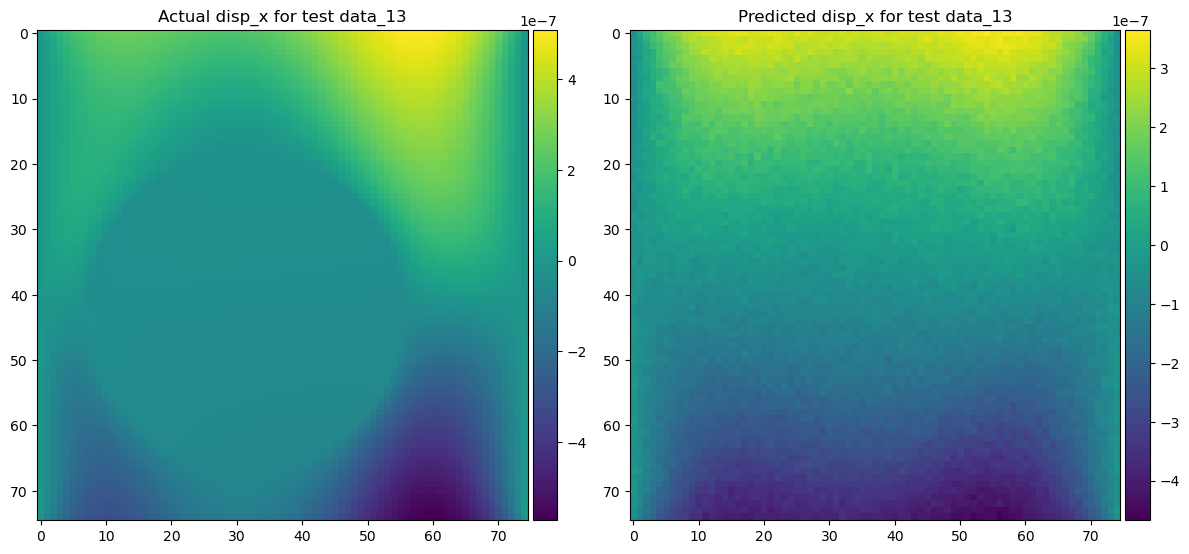

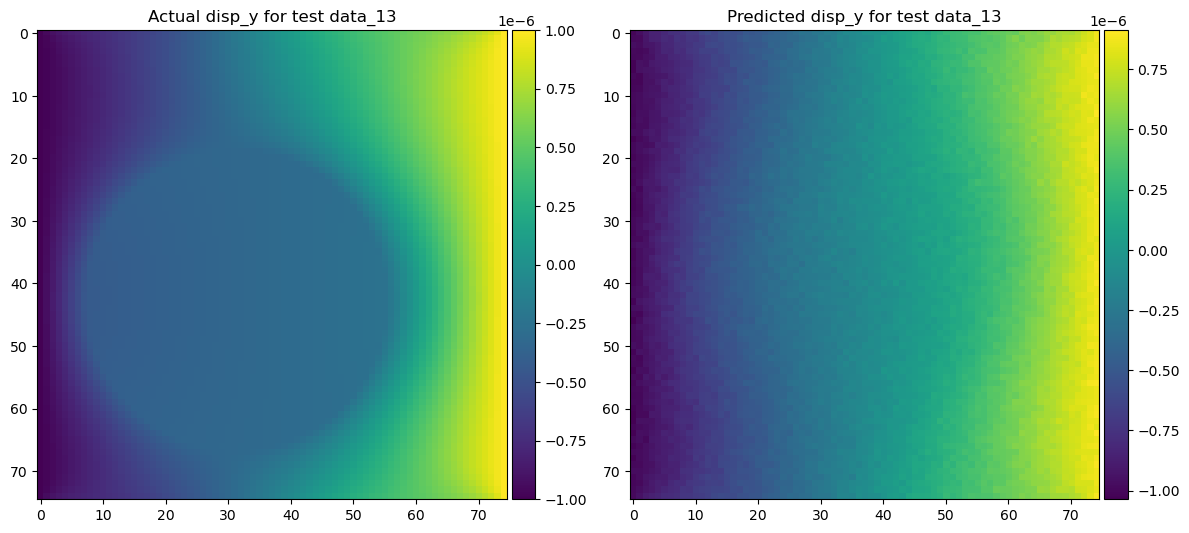

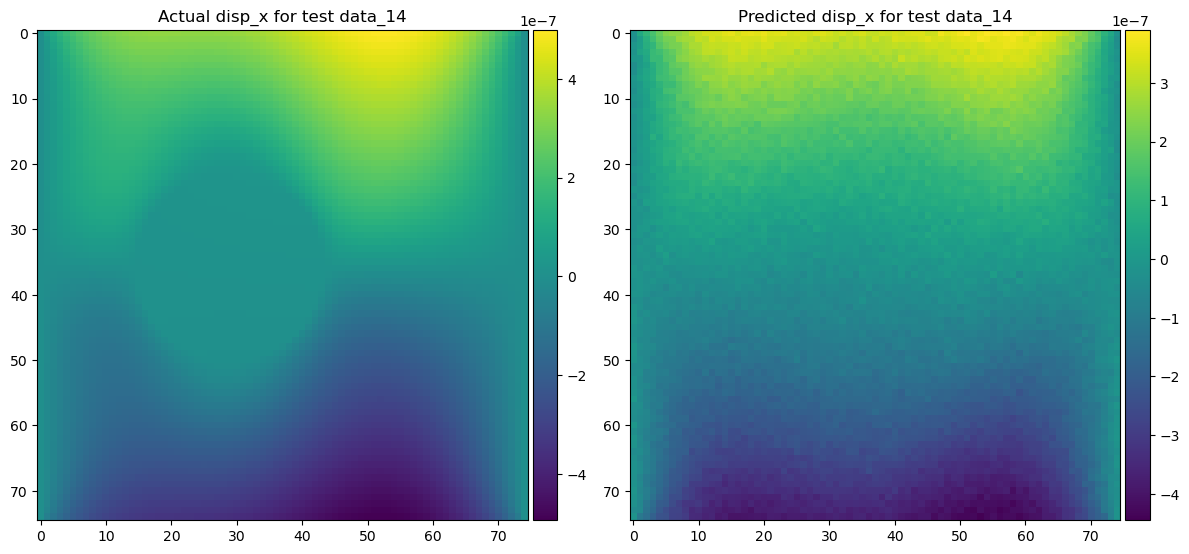

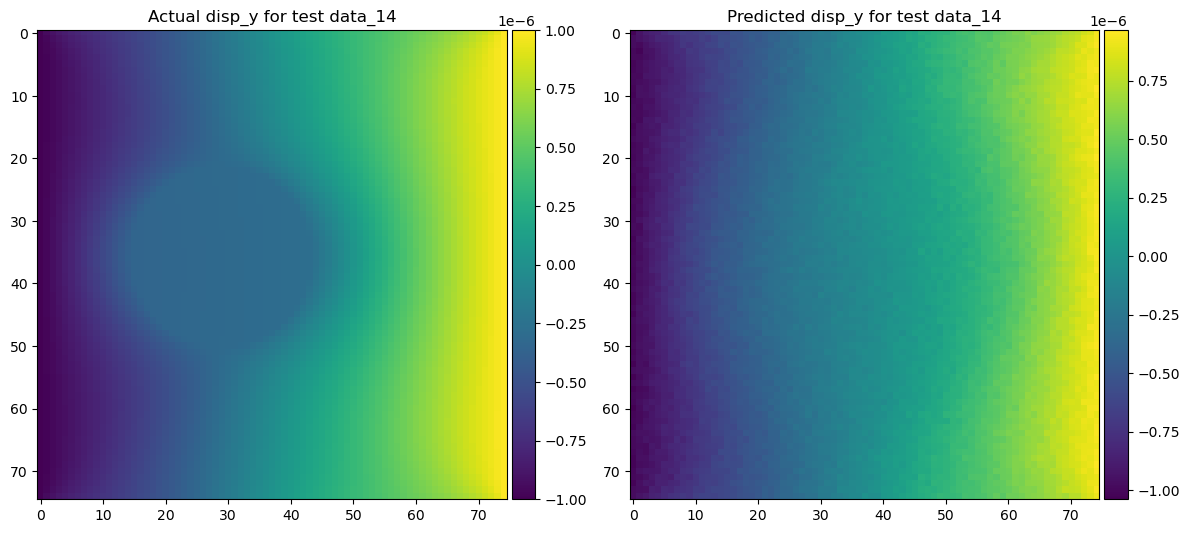

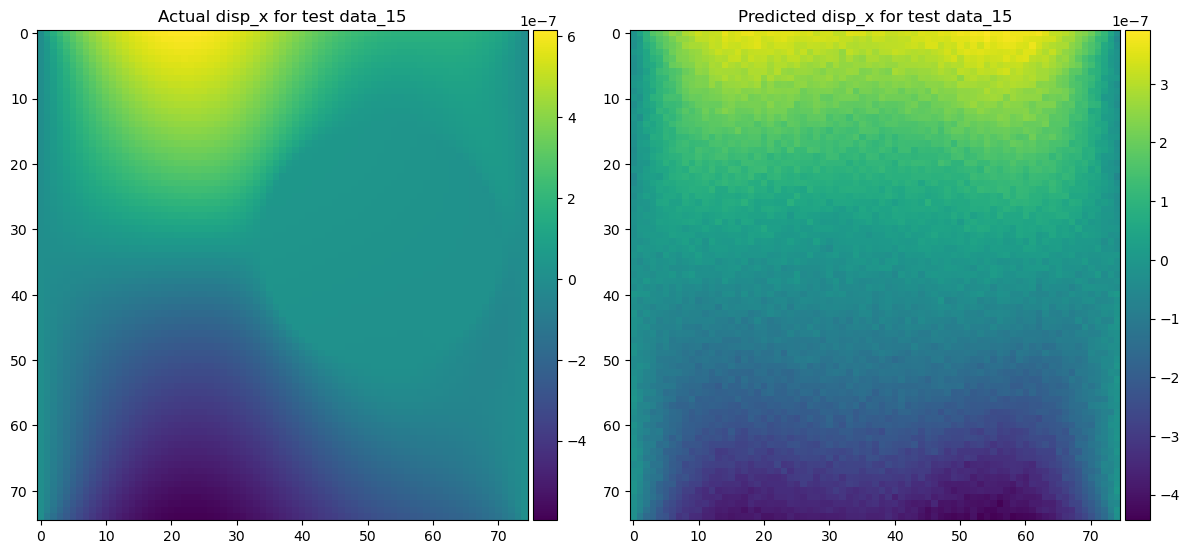

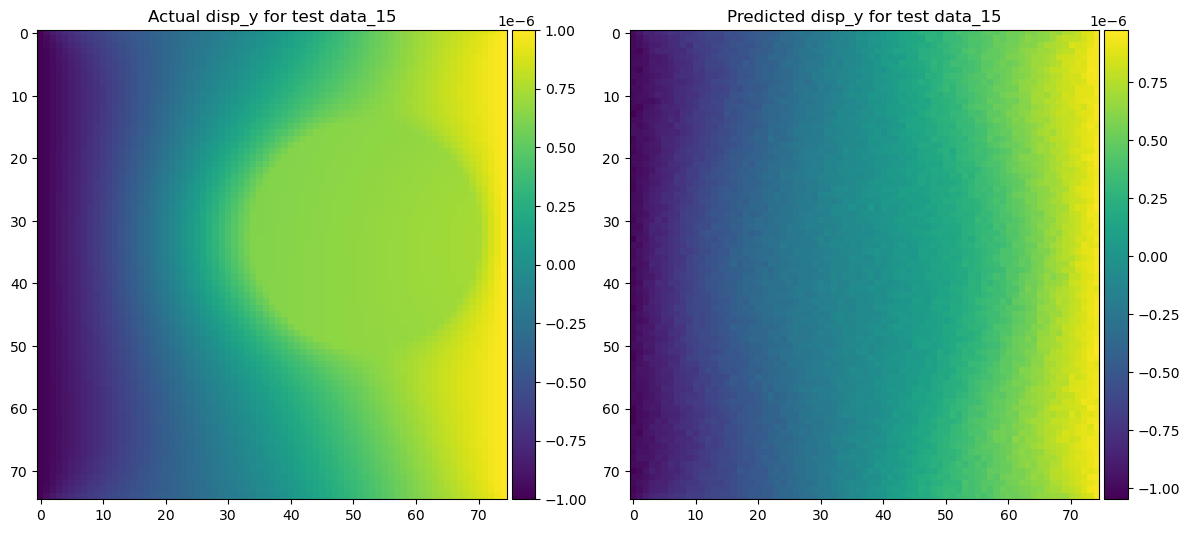

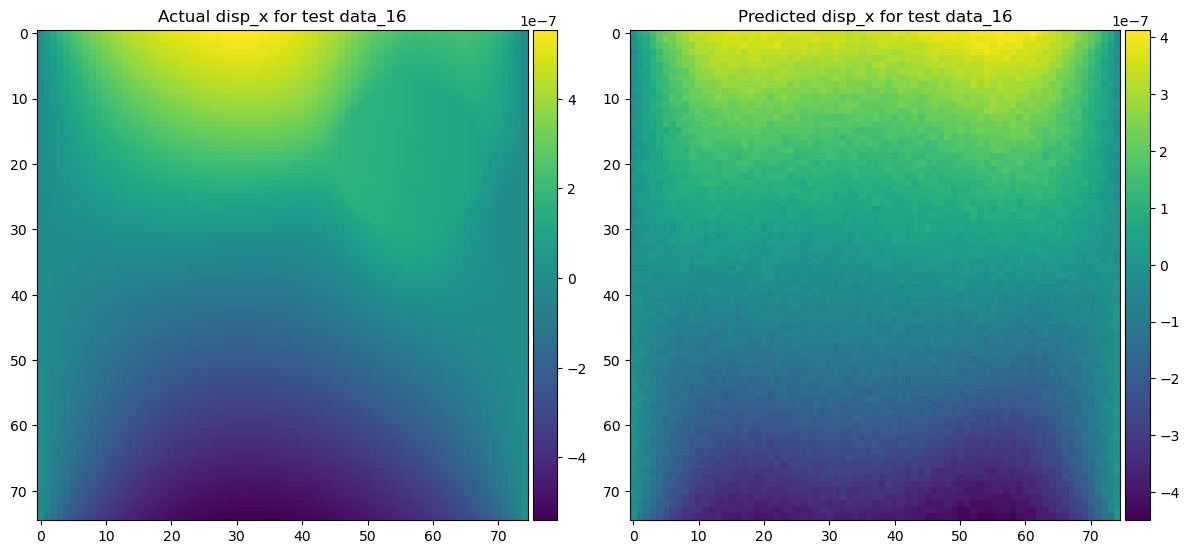

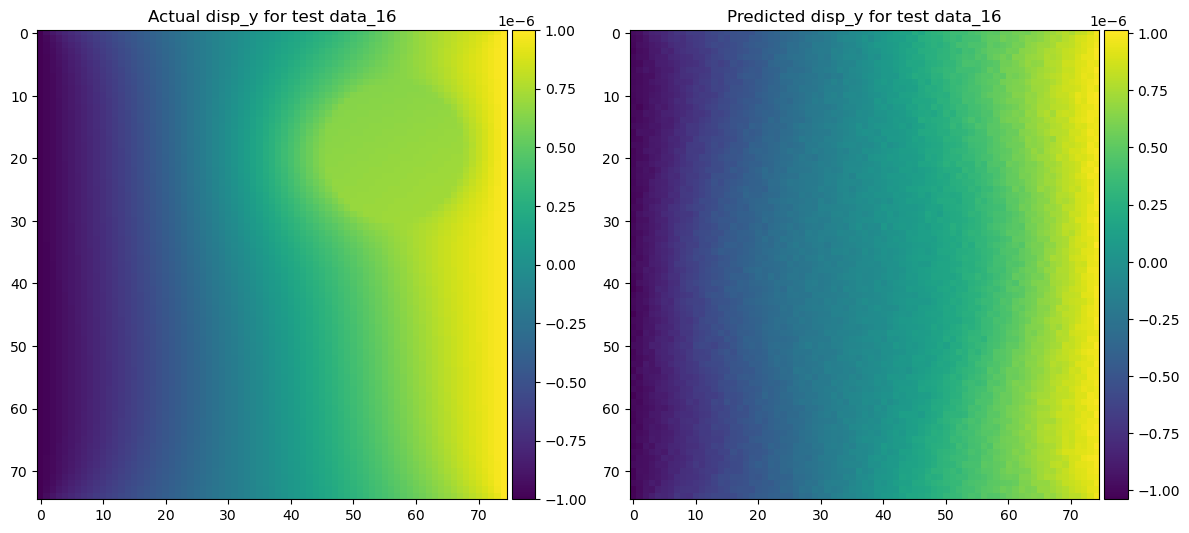

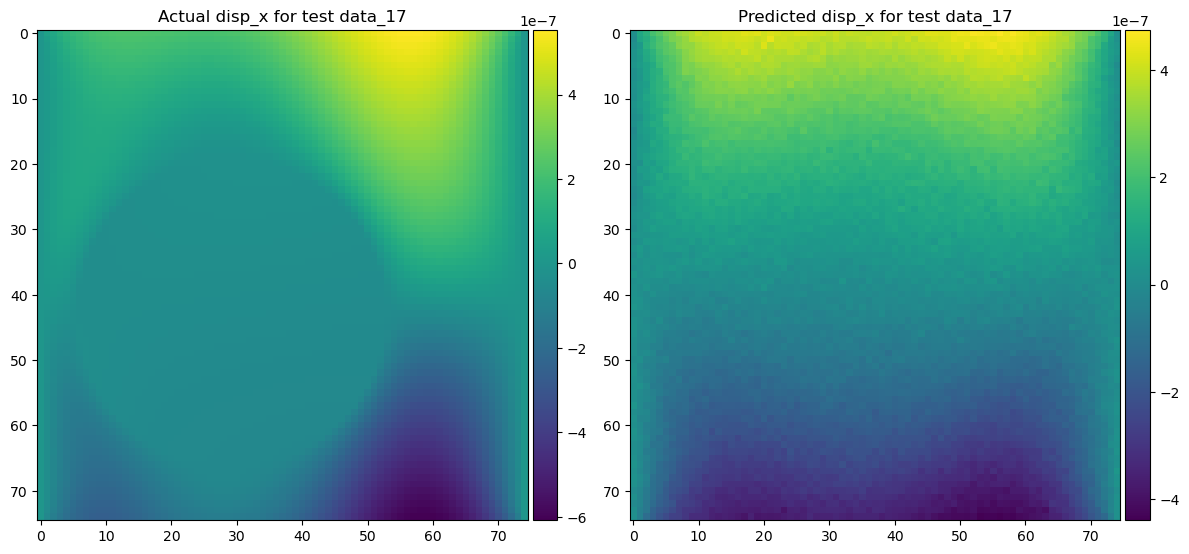

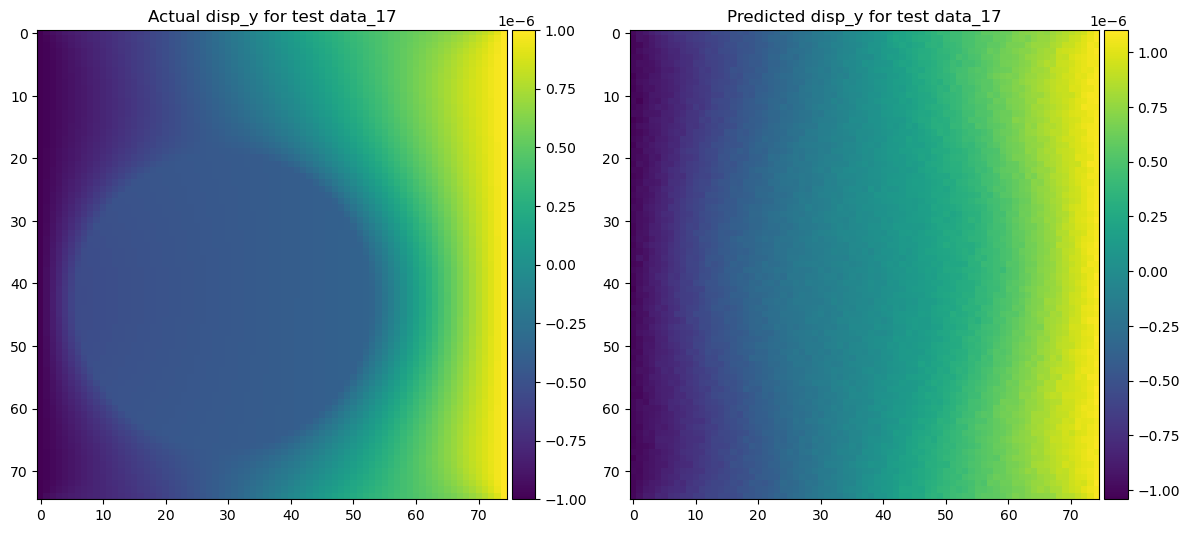

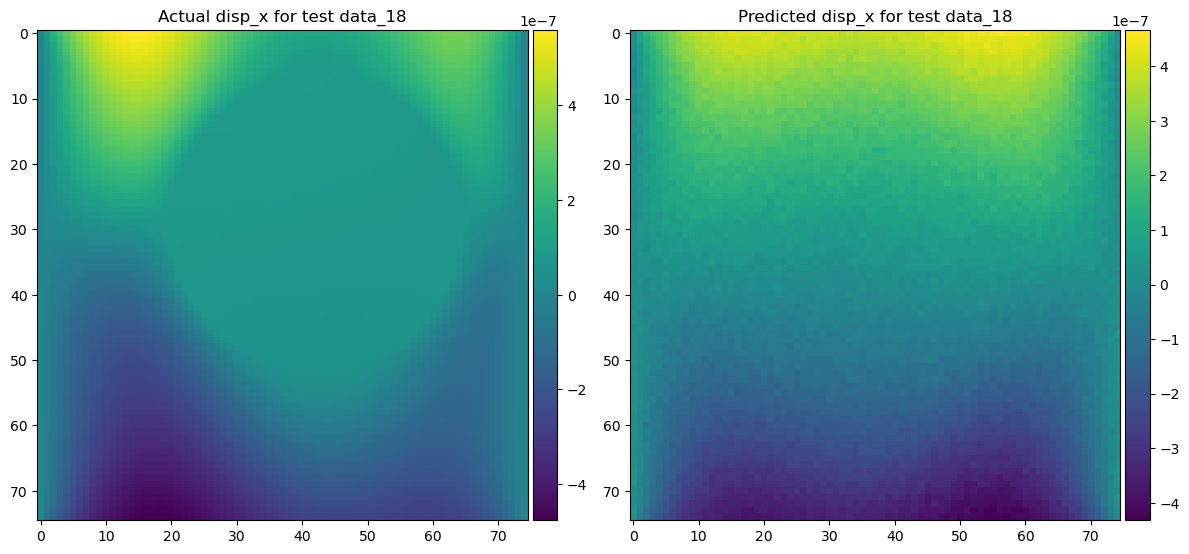

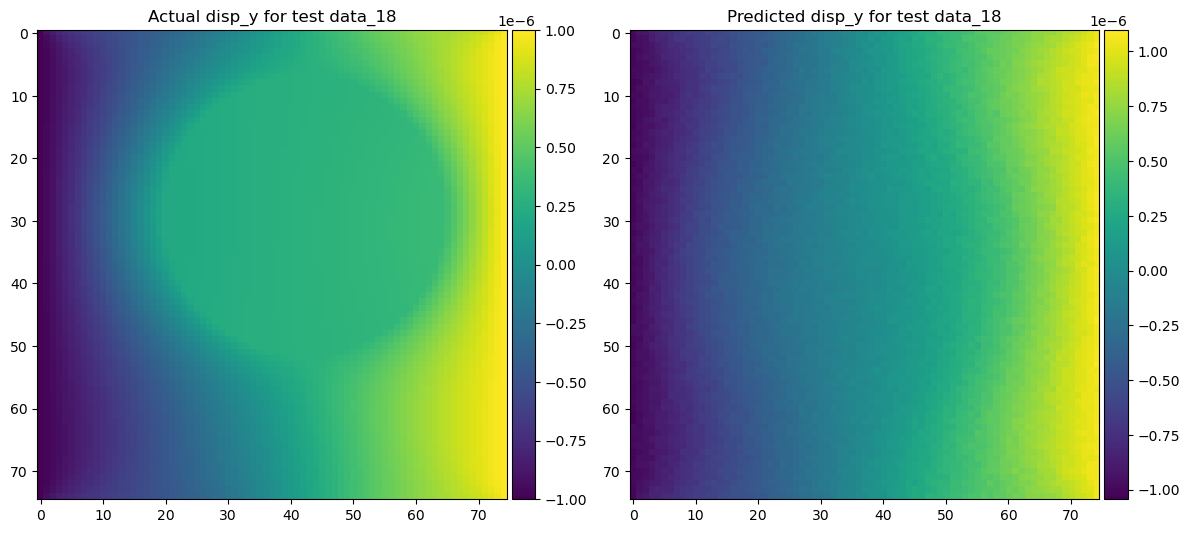

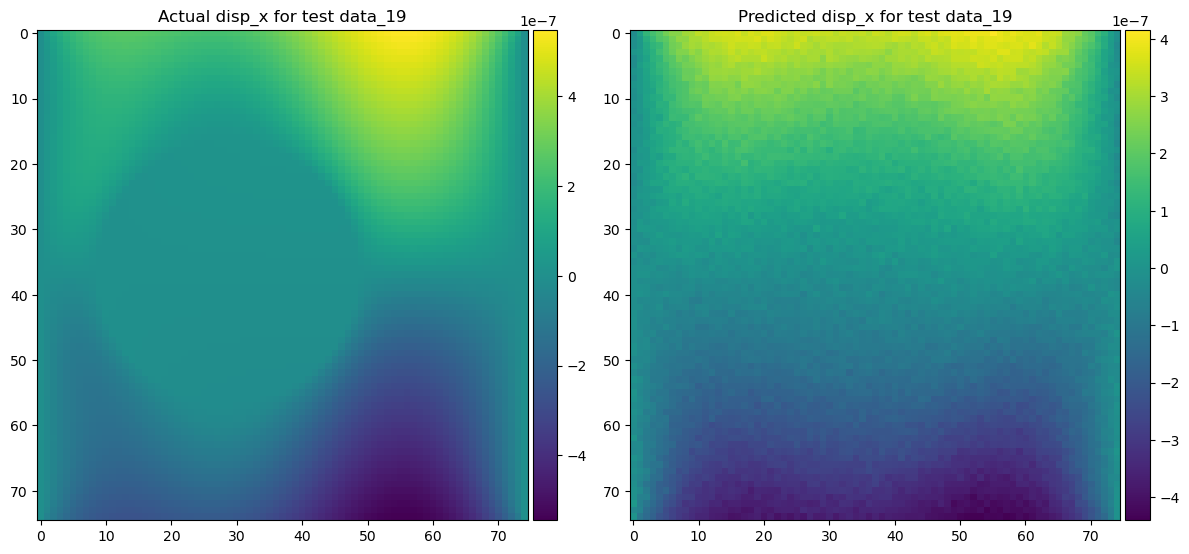

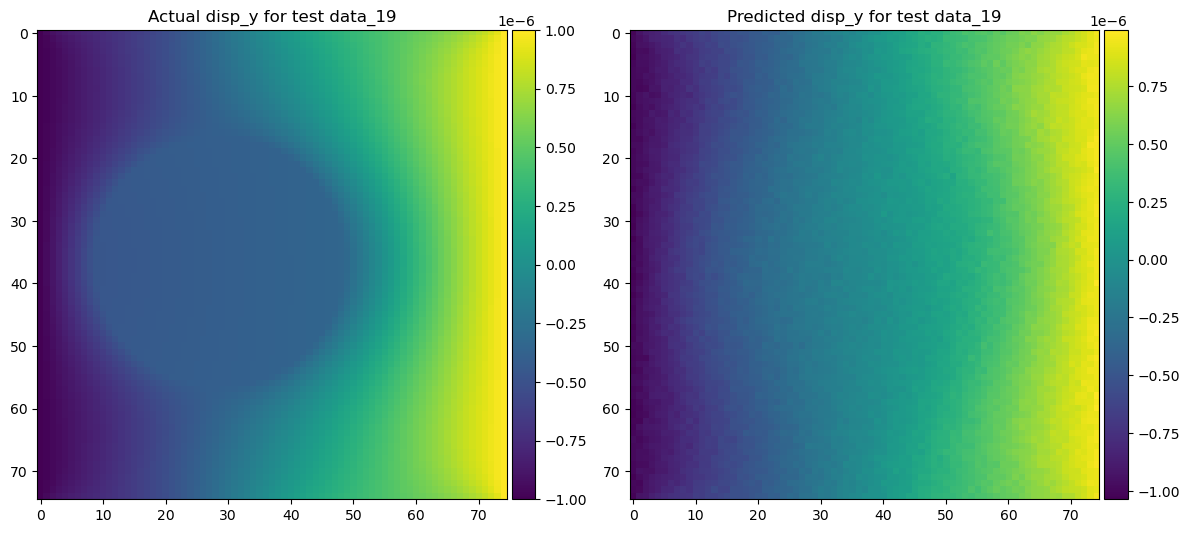

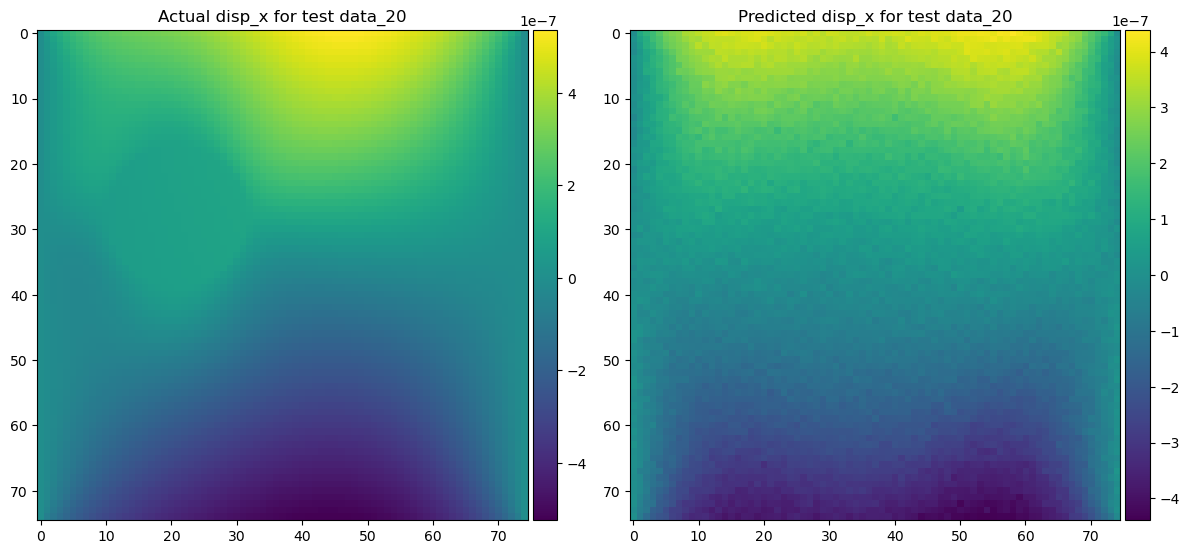

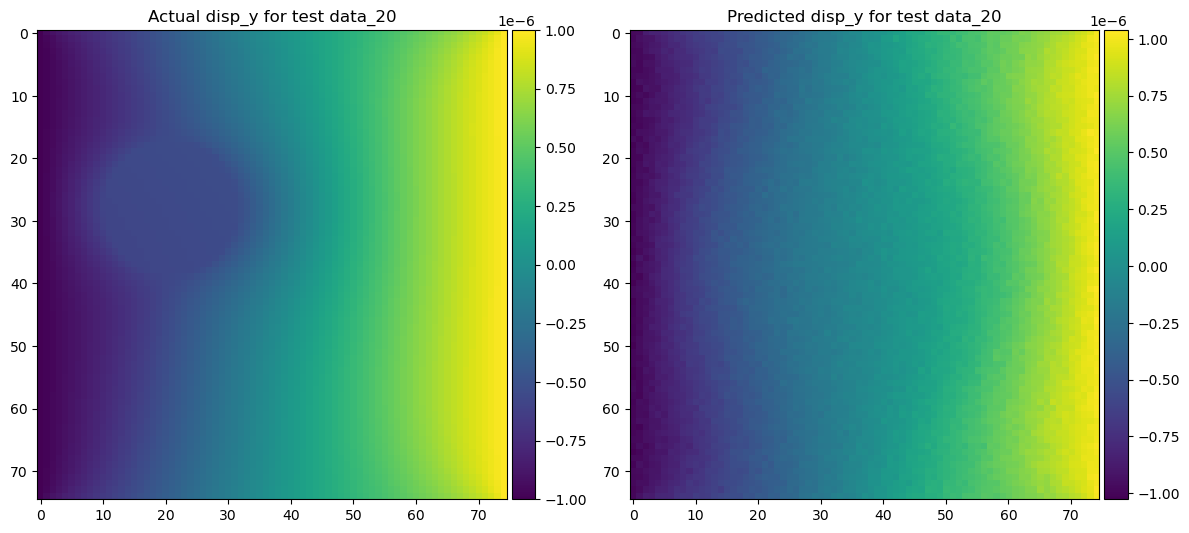

In [16]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Loop through all samples
for sample_index in range(20):  # assuming you have 20 test samples

    # Extract the x and y displacements from the predictions and actual values
    predicted_disp_x = predictions[sample_index, :, :, 0]
    predicted_disp_y = predictions[sample_index, :, :, 1]

    actual_disp_x = test_disp[sample_index, :, :, 0]
    actual_disp_y = test_disp[sample_index, :, :, 1]

    # Plot for disp_x
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
    
    im1 = ax1.imshow(actual_disp_x, cmap='viridis')
    ax1.set_title(f"Actual disp_x for test data_{sample_index + 1}")
    divider = make_axes_locatable(ax1)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im1, cax=cax)

    im2 = ax2.imshow(predicted_disp_x, cmap='viridis')
    ax2.set_title(f"Predicted disp_x for test data_{sample_index + 1}")
    divider = make_axes_locatable(ax2)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im2, cax=cax)

    plt.tight_layout()
    plt.show()

    # Plot for disp_y
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
    
    im1 = ax1.imshow(actual_disp_y, cmap='viridis')
    ax1.set_title(f"Actual disp_y for test data_{sample_index + 1}")
    divider = make_axes_locatable(ax1)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im1, cax=cax)

    im2 = ax2.imshow(predicted_disp_y, cmap='viridis')
    ax2.set_title(f"Predicted disp_y for test data_{sample_index + 1}")
    divider = make_axes_locatable(ax2)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im2, cax=cax)

    plt.tight_layout()
    plt.show()
